## Region based segmentation using annotated public "COVID-19 CT segmentation dataset"

* The algorithm explores K-means clustering (k=2) for lung segmetnation. 
* The dice coeffecient was used to measure the preformance of the segmetnation method.
* The annotated CT images at http://medicalsegmentation.com/covid19/
was used.
* From the annotated dataset: the Image volumes (308 Mb), and the Lung masks (1 Mb) were used to validate the segmentaiton performacne.
* The images and masks were sliced in Z acial direction.

In [2]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
 
from tensorflow import keras
from PIL import Image as im
import skimage
from skimage.filters import sobel
from skimage import morphology
from skimage.feature import canny
#from scipy import ndimage as ndi
from skimage import io
from skimage.exposure import histogram
# Mounting my google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


# Slicing and Saving

In [3]:
## The path here include the image volumes (308MB) and the lung masks (1MB) were extracted from the COVID-19 CT segmentation dataset
dataInputPath = '/content/gdrive/MyDrive/Segmentation/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/') ## Image volumes were exctracted to this subfolder
maskPathInput = os.path.join(dataInputPath, 'mask/') ## lung masks were exctracted to this subfolder

# Preparing the outputpath for slicing the CT volume from the above data
dataOutputPath = '/content/gdrive/MyDrive/Segmentation/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/') ## Image volume slices will be placed here
maskSliceOutput = os.path.join(dataOutputPath, 'mask/') ## Annotated masks slices will be placed here

# Slicing only in Z direction
# Slices in Z direction shows the required lung area
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [4]:
# Choosing normalization boundaries suitable from the chosen images
HOUNSFIELD_MIN = -1020
HOUNSFIELD_MAX = 2995
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# Normalizing the images
def normalizeImageIntensityRange (img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

#nImg = normalizeImageIntensityRange(img)
#np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

# Reading image or mask volume
def readImageVolume(imgPath, normalize=True):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
#readImageVolume(imgPath, normalize=False)
#readImageVolume(maskPath, normalize=False)

# Slicing image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

# Saving volume slices to file
def saveSlice (img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

# Slicing volumes and lung masks and saving them in "slices" folder

In [5]:
# Reading and processing image volumes for TEST images
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

# Reading and processing image mask volumes for TEST masks
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/gdrive/MyDrive/Segmentation/volumes/img/1.nii.gz (630, 630, 45) 1305 0.0 0.3070329411982896
630 630 45
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t0-slice044_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/1.nii.gz, 45 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/2.nii.gz (630, 630, 39) 1299 0.0 0.29788061310612546
630 630 39
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t1-slice038_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/2.nii.gz, 39 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/3.nii.gz (630, 630, 418) 1678 0.0 0.28805189310836316
630 630 418
Slicing Z: 
[+] Slice saved: /content/gdrive/MyDrive/Segmentation/slices/img/t2-slice417_z.png
/content/gdrive/MyDrive/Segmentation/volumes/img/3.nii.gz, 418 slices created 

/content/gdrive/MyDrive/Segmentation/volumes/img/4.nii.gz (630, 630, 39) 1299 0.0 0.29359098175542886
630 630 39
Slicing Z: 
[+] Slice sa

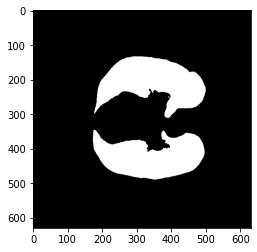

In [6]:
# Exploring the data 
imgPath = os.path.join(imagePathInput, '1.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)


maskPath = os.path.join(maskPathInput, '1.nii.gz')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

# Showing image slice
imgSlice = mask[:,:,20]
plt.imshow(imgSlice, cmap='gray')
plt.show()

## K-means Clustering Based Segmentation

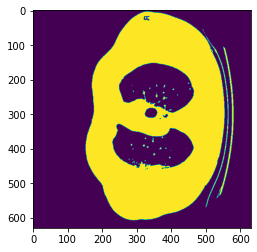

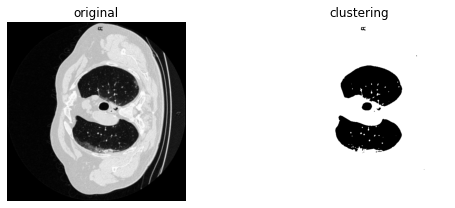

In [33]:
## Reading the image in gray scale and gussian blurring
n= cv2.imread("/content/gdrive/MyDrive/Segmentation/slices/img/t0-slice009_z.png")
# Converting to Grayscale
n= cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
# Bluring the images
n = cv2.GaussianBlur(n, (5, 5), 0)
image = n

# Reshaping the image into a 2D array of pixels and 1 color values (Grayscale)
pixel_vals = image.reshape((-1,1))

# Convert to float type
pixel_vals = np.float32(pixel_vals)

#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 2
#also random centres are initially choosed for k-means clustering
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)

segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))


## Binarizing the resulting segmented image
(thresh, segmented_image) = cv2.threshold(segmented_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(segmented_image)# Modifying the background to exctract the segmetned lungs

## Exctracing only the lungs  from the segmented images (removing the back ground to keep only lungs)
ret, gray = ret, gray = cv2.threshold(segmented_image.astype(np.uint8), 1, 255, cv2.THRESH_BINARY)
for x in range(gray.shape[1]):
    # Fill dark top pixels:
    if gray[0, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, 0), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark bottom pixels:
    if gray[-1, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, gray.shape[0]-1), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    
for y in range(gray.shape[0]):
    # Fill dark left side pixels:
    if gray[y, 0] == 0:
      cv2.floodFill(gray, None, seedPoint=(0, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark right side pixels:
    if gray[y, -1] == 0:
      cv2.floodFill(gray, None, seedPoint=(gray.shape[1]-1, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    
    #file_name, file_ext = os.path.splitext(m)
    #gray = im.fromarray(gray)
    #gray.save('{}.png'.format(file_name))


## Plotting the original image and the final results of k-means clustered image
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(n , cmap=plt.cm.gray)
axes[0].set_title('original')

axes[1].imshow(gray, cmap=plt.cm.gray)
axes[1].set_title('clustering')
for a in axes:
     a.axis('off')




plt.tight_layout()


## Replacing images with their segmented slices in the directory

In [34]:
## The images in the "/content/gdrive/MyDrive/Segmentation/slices/img/*.png" will be replaced by their masks via region based segmetnation

for m in glob.glob("/content/gdrive/MyDrive/Segmentation/slices/img/*.png"):
 n=cv2.imread(m)
 n= cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
 n = cv2.GaussianBlur(n, (5, 5), 0)
 image = n

 # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
 pixel_vals = image.reshape((-1,1))

 # Convert to float type
 pixel_vals = np.float32(pixel_vals)

#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
 criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
 k = 2
 retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
 centers = np.uint8(centers)

 segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
 segmented_image = segmented_data.reshape((image.shape))

 (thresh, segmented_image) = cv2.threshold(segmented_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#plt.imshow(segmented_image)# Modifying the background to exctract the segmetned lungs

 ret, gray = ret, gray = cv2.threshold(segmented_image.astype(np.uint8), 1, 255, cv2.THRESH_BINARY)
 for x in range(gray.shape[1]):
    # Fill dark top pixels:
    if gray[0, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, 0), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark bottom pixels:
    if gray[-1, x] == 0:
      cv2.floodFill(gray, None, seedPoint=(x, gray.shape[0]-1), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    
 for y in range(gray.shape[0]):
    # Fill dark left side pixels:
    if gray[y, 0] == 0:
      cv2.floodFill(gray, None, seedPoint=(0, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    # Fill dark right side pixels:
    if gray[y, -1] == 0:
      cv2.floodFill(gray, None, seedPoint=(gray.shape[1]-1, y), newVal=255, loDiff=3, upDiff=3)  # Fill the background with white color
    
 file_name, file_ext = os.path.splitext(m)
 gray = im.fromarray(gray)
 gray.save('{}.png'.format(file_name))

## Using Dice Coeffecient for measuring the perforrmamce of the Segmentation 

In [35]:
## Segmetnation Quantifying Measure (Dice coeffecient)

def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            
            lenIntersection=0
            
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: De

(630, 630, 3)
(630, 630, 3)
Dice coeffecient value is 0.8576114890400605


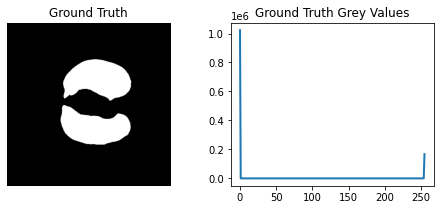

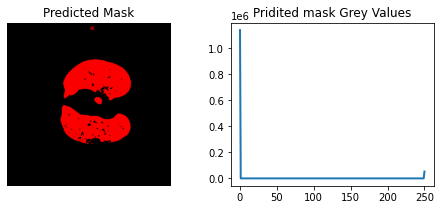

In [36]:
## Ground Truth Mask
img = cv2.imread('/content/gdrive/MyDrive/Segmentation/slices/mask/t0-slice012_z.png')

hist, hist_centers = histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Ground Truth Grey Values')

#print(img)
img = np.asarray(img).astype(np.bool)
#print(img)
print(img.shape)
#print('_'*40)

## Predicted mask
img2 = cv2.imread('/content/gdrive/MyDrive/Segmentation/slices/img/t0-slice012_z.png')
img2 = cv2.subtract(250, img2)

hist, hist_centers = histogram(img2)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img2, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('Predicted Mask')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Pridited mask Grey Values')

#print(img2)
img2 = np.asarray(img2).astype(np.bool)

#print(img2)
print(img2.shape)
#print('%'*40)

value = dice_coef(img, img2)
print("Dice coeffecient value is", value) 

## Checking Dice values for all slices in the dataset (image volumes and lung musks)

In [37]:
GT_path = '/content/gdrive/MyDrive/Segmentation/slices/mask/'
pred_path = '/content/gdrive/MyDrive/Segmentation/slices/img/'

import os

# specify the img directory path
path = "path/to/img/folder/"

# list files in img directory
files = os.listdir(GT_path)
files2 = os.listdir(pred_path)

dicee = []
for file in files:
    # make sure file is an image
    if file.endswith('.png'):
      for filee in files2:
        if filee == file:
          ## Ground Truth Mask
          img = cv2.imread(GT_path + file)
          img = np.asarray(img).astype(np.bool)

          ## Predicted mask
          img2 = cv2.imread(pred_path + filee)
          img2 = cv2.subtract(250, img2)
          img2 = np.asarray(img2).astype(np.bool)

          value = dice_coef(img, img2)
          print("Dice coeffecient value is", value, "\n") 
          dicee.append(value)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Dice coeffecient value is 0.9982111363063744 

Dice coeffecient value is 0.9925018896447468 

Dice coeffecient value is 0.9780977576215671 

Dice coeffecient value is 0.963119173595364 

Dice coeffecient value is 0.9503980851599899 

Dice coeffecient value is 0.9360644998740237 

Dice coeffecient value is 0.9220005039052658 

Dice coeffecient value is 0.9072889896699421 

Dice coeffecient value is 0.8977047115142354 

Dice coeffecient value is 0.8864222726127488 

Dice coeffecient value is 0.8746384479717813 

Dice coeffecient value is 0.8650062988158226 

Dice coeffecient value is 0.8576114890400605 

Dice coeffecient value is 0.8499899218946838 

Dice coeffecient value is 0.8454195011337868 

Dice coeffecient value is 0.8448551272360796 

Dice coeffecient value is 0.842108843537415 

Dice coeffecient value is 0.8383749055177626 

Dice coeffecient value is 0.8396271101033006 

Dice coeffecient value is 0.8401133786848073 

Dice coeffecient value is 0.8412446460065508 

Dice coeffecien

In [40]:
dicee = np.array(dicee)

len = len(dicee)
print("Number of Values is", len)

# Taking average of dice values
av=np.mean(dicee)
print ("average dice values is", av)

# Taking maximuim and minimuim of dice values
mx=np.max(dicee)
print ("maximuim dice values is", mx)

mn=np.min(dicee)
print ("minimuim dice values is", mn)

Number of Values is 829
average dice values is 0.8938017889548706
maximuim dice values is 0.9998034769463341
minimuim dice values is 0.7512496850592089
